In [1]:
import numpy as np
import pandas as pd
from scipy.special import erf, expit, logit, gammaln
from scipy.signal import convolve
from scipy.optimize import minimize, basinhopping
from sklearn.mixture import BayesianGaussianMixture
from tqdm import tqdm
from data_interface import load_behavioral_data
from compress_pickle import load, dump
import os
from matplotlib import pyplot as plt
import matplotlib.colors as mc

In [2]:
def take_along_axis(arr, indices, axis):
    if axis < 0:
        axis = arr.ndim + axis
    if axis < 0 or axis >= arr.ndim:
        raise ValueError("axis is out of number of dimensions")
    arr_shape = arr.shape
    return arr[_make_along_axis_idx(arr_shape, indices, axis)]

In [3]:
def _make_along_axis_idx(arr_shape, indices, axis):
    # compute dimensions to iterate over
    if len(arr_shape) != indices.ndim:
        raise ValueError("`indices` and `arr` must have the same number of dimensions")
    shape_ones = (1,) * indices.ndim
    dest_dims = list(range(axis)) + [None] + list(range(axis + 1, indices.ndim))

    # build a fancy index, consisting of orthogonal aranges, with the
    # requested index inserted at the right location
    fancy_index = []
    for dim, n in zip(dest_dims, arr_shape):
        if dim is None:
            fancy_index.append(indices)
        else:
            ind_shape = shape_ones[:dim] + (-1,) + shape_ones[dim + 1 :]
            fancy_index.append(np.arange(n).reshape(ind_shape))

    return tuple(fancy_index)

In [4]:
def _richards(x, nu, lam):
    return lam * (1 - 1 / (1 + np.exp(10 * x)) ** (1 / nu)) + 1e-4

In [5]:
class Population:
    def __init__(self, parameters_df, n_components=5, gmm_on_parameters=None):
        gmm = BayesianGaussianMixture(
            n_components=n_components,
            covariance_type="full",
            n_init=10,
            weight_concentration_prior_type="dirichlet_process",
            weight_concentration_prior=1e-6,
        )
        self.parameters = parameters_df.xs("mean", axis=1, level=1)
        self.set_gmm_parameters(gmm_on_parameters)
        self.gmm = gmm.fit(self.gmm_parameters)

    def set_gmm_parameters(self, gmm_on_parameters=None):
        if gmm_on_parameters is None:
            gmm_on_parameters = ["nu", "lam", "I0", "I1", "I1p", "I2", "I2p", "I3p"]
        self.gmm_parameters = self.parameters[gmm_on_parameters]
        self.gmm_columns = gmm_on_parameters
        self.median_columns = [c for c in self.parameters if c not in gmm_on_parameters]
        self.medians = self.parameters[self.median_columns].median(axis=0)
        if "mech_onset" in self.medians:
            self.medians["mech_onset"] = 0
        if "mech_offset" in self.medians:
            self.medians["mech_offset"] = 0

    def sample(self, n_samples=1):
        samples, label = self.gmm.sample(n_samples)
        output = pd.DataFrame(data=samples, columns=self.gmm_columns)
        output = output.assign(
            **{k: v * np.ones(n_samples) for k, v in self.medians.items()}
        )
        return output.assign(label=label)

    def response_rate(self, t, T, mech=True, light=False, samples=None, reduce=True):
        if samples is None:
            samples = self.sample()[0]
        onset = 0.0
        nu = samples["nu"].values
        lam = samples["lam"].values
        I0 = samples["I0"].values
        I1 = samples["I1"].values
        I1p = samples["I1p"].values
        I2 = samples["I2"].values
        I2p = samples["I2p"].values
        I3p = samples["I3p"].values
        tau = samples["tau"].values
        tau_opto = samples["tau_opto"].values
        tau_inh = samples["tau_inh"].values

        offset_t = t - T
        w = expit(1 * (t - onset)) * expit(-1 * (offset_t - onset))
        if light:
            w2 = expit(1 * (offset_t - onset))
        else:
            w2 = 0.0
        if mech and light:
            input_current = I0 + (
                w
                * (
                    I1
                    + (I1p - I1) * np.exp(-(t - onset) / tau)
                    + I2
                    + (I2p - I2) * np.exp(-(t - onset) / tau_opto)
                )
                + w2 * I3p * np.exp(-(offset_t - onset) / tau_inh)
            )
        elif mech:
            input_current = I0 + (w * (I1 + (I1p - I1) * np.exp(-(t - onset) / tau)))
        elif light:
            input_current = I0 + (
                w * (I2 + (I2p - I2) * np.exp(-(t - onset) / tau_opto))
                + w2 * I3p * np.exp(-(offset_t - onset) / tau_inh)
            )
        else:
            I0, t = np.broadcast_arrays(I0, t)
            input_current = I0
        rate = _richards(input_current, nu, lam)
        if reduce:
            rate = np.sum(rate, axis=-1)
        return rate

    def no_light_drive(
        self, t, T, contralateral_parameters=None, ipsilateral_parameters=None
    ):
        if contralateral_parameters is None:
            contralateral_parameters = self.sample(n_samples=1000)
        if ipsilateral_parameters is None:
            ipsilateral_parameters = self.sample(n_samples=1000)
        contra_rate = self.response_rate(
            t=t[..., None],
            T=T[..., None],
            mech=True,
            light=False,
            samples=contralateral_parameters,
            reduce=True,
        )
        ipsi_rate = self.response_rate(
            t=t[..., None],
            T=T[..., None],
            mech=False,
            light=False,
            samples=ipsilateral_parameters,
            reduce=True,
        )
        return contra_rate + ipsi_rate

    def contralateral_light_drive(
        self, t, T, contralateral_parameters=None, ipsilateral_parameters=None
    ):
        if contralateral_parameters is None:
            contralateral_parameters = self.sample(n_samples=1000)
        if ipsilateral_parameters is None:
            ipsilateral_parameters = self.sample(n_samples=1000)
        contra_rate = self.response_rate(
            t=t[..., None],
            T=T[..., None],
            mech=True,
            light=True,
            samples=contralateral_parameters,
            reduce=True,
        )
        ipsi_rate = self.response_rate(
            t=t[..., None],
            T=T[..., None],
            mech=False,
            light=False,
            samples=ipsilateral_parameters,
            reduce=True,
        )
        return contra_rate + ipsi_rate

    def ipsilateral_light_drive(
        self, t, T, contralateral_parameters=None, ipsilateral_parameters=None
    ):
        if contralateral_parameters is None:
            contralateral_parameters = self.sample(n_samples=1000)
        if ipsilateral_parameters is None:
            ipsilateral_parameters = self.sample(n_samples=1000)
        contra_rate = self.response_rate(
            t=t[..., None],
            T=T[..., None],
            mech=False,
            light=True,
            samples=contralateral_parameters,
            reduce=True,
        )
        ipsi_rate = self.response_rate(
            t=t[..., None],
            T=T[..., None],
            mech=True,
            light=False,
            samples=ipsilateral_parameters,
            reduce=True,
        )
        return contra_rate + ipsi_rate

In [6]:
def leaky_integrator(t, drive, tau=600.0):
    kernel = np.exp(-t / tau) / tau
    if kernel.ndim < drive.ndim:
        kernel = kernel[(np.newaxis,) * (drive.ndim - kernel.ndim) + (slice(None),)]
    LI = convolve(drive, kernel)[..., : kernel.shape[-1]]
    return LI

In [7]:
def rescale_parameters(
    tau_log, background_mean, background_var_log, lapse_rate_logodds, lapse_bias_logodds
):
    return (
        np.exp(tau_log),
        background_mean,
        np.exp(background_var_log),
        expit(lapse_rate_logodds),
        expit(lapse_bias_logodds),
    )

In [8]:
def predicted_li(
    drives,
    T_ind,
    ref_drives,
    ref_ind,
    T_ref_ind,
    tau_log=6.4,
    background_mean=0,
    background_var_log=-np.inf,
    lapse_rate_logodds=-np.inf,
    lapse_bias_logodds=0.0,
    t=None,
):
    # Rescale parameters to their true domain
    tau, background_mean, background_var, lapse_rate, lapse_bias = rescale_parameters(
        tau_log,
        background_mean,
        background_var_log,
        lapse_rate_logodds,
        lapse_bias_logodds,
    )
    if t is None:
        t = np.arange(drives.shape[-1], dtype=np.float)

    # Precompute some factors
    back_drive = background_mean * tau * (1 - np.exp(-t / tau))
    back_drive_var = background_var * 0.5 * tau * (1 - np.exp(-2 * t / tau))

    # Compute the drives
    li = leaky_integrator(t, drives, tau) + back_drive
    li_var = leaky_integrator(t, drives, 0.5 * tau) + back_drive_var
    return li, li_var

In [9]:
def setup_drives(
    population,
    T,
    t,
    n_samples,
    reps=200,
    kinds=["no_light", "contralateral_light"],
    contralateral_parameters=None,
    ipsilateral_parameters=None,
):
    _kind_map = {
        "no_light": "no_light_drive",
        "contralateral_light": "contralateral_light_drive",
        "ipsilateral_light": "ipsilateral_light_drive",
    }
    drives = np.empty((reps, len(kinds), len(T), len(t)), dtype="float")
    cp = []
    ip = []
    for i, rep in enumerate(tqdm(range(reps), desc="Setting up population drives")):
        if contralateral_parameters is None:
            contra_parameters = population.sample(n_samples=n_samples)
            cp.append(contra_parameters)
        else:
            contra_parameters = contralateral_parameters[i]
        if ipsilateral_parameters is None:
            ipsi_parameters = population.sample(n_samples=n_samples)
            ip.append(ipsi_parameters)
        else:
            ipsi_parameters = ipsilateral_parameters[i]
        for i, kind in enumerate(kinds):
            method = _kind_map[kind]
            drive = getattr(population, method)(
                t,
                T[..., None],
                contralateral_parameters=contra_parameters,
                ipsilateral_parameters=ipsi_parameters,
            )
            drives[rep, i] = drive
    return drives, cp, ip

In [10]:
parameters_df = pd.read_hdf(os.path.join("simple_model_fits", "parameters.h5"))
pop = Population(parameters_df=parameters_df)
temp = load(
    os.path.join(
        "simple_model_fits", "behavioral_parameters.pkl"
    )
)
results = temp["results"]
contra_parameters = temp["contralateral_parameters"]
ipsi_parameters = temp["ipsilateral_parameters"]
T = np.array([780])
t = np.arange(T[0], dtype="float")
drives = setup_drives(
    pop,
    T,
    t,
    n_samples=5000,
    reps=len(contra_parameters),
    kinds=["no_light", "contralateral_light", "ipsilateral_light"],
    contralateral_parameters=contra_parameters,
    ipsilateral_parameters=ipsi_parameters,
)[0]
ref_drives = drives[:, :, 0]
drives = drives[:, [0, 1, 0, 2], 0]
T_ind = np.arange(143, 780, dtype="int")
T_ref_ind = 334
ref_ind = np.array([1, 0, 2, 0])[:, None]


Setting up population drives: 100%|██████████| 100/100 [05:25<00:00,  3.26s/it]


In [18]:
li, li_var = predicted_li(drives, T_ind,
    ref_drives,
    ref_ind,
    T_ref_ind,
    tau_log=6.4,
    background_mean=0,
    background_var_log=-np.inf,
    lapse_rate_logodds=-np.inf,
    lapse_bias_logodds=0.0,
    t=None,)

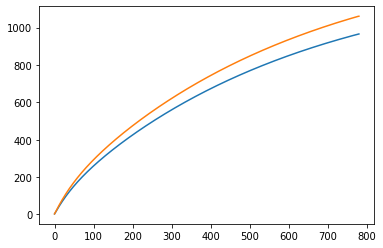

In [21]:
_li = np.mean(li[:, :2], axis=0)
_li_var = np.mean(li_var[:, :2], axis=0)
plt.plot(_li.T)

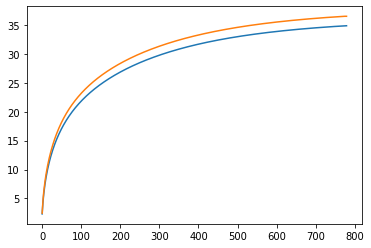

In [22]:
plt.plot(np.sqrt(_li_var.T))

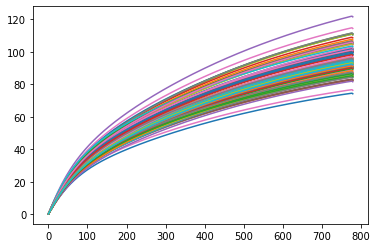

In [29]:
plt.plot((li[:, 1] - li[:, 0]).T);

In [36]:
tactile_drive = li[:, 0]
tactile_drive_contra_opto = li[:, 1]
tactile_drive_ipsi_opto = li[:, 3]
tactile_drive_std = np.sqrt(li_var[:, 0])
tactile_drive_contra_opto_std = np.sqrt(li_var[:, 1])
tactile_drive_ipsi_opto_std = np.sqrt(li_var[:, 3])

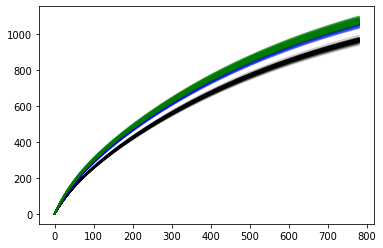

In [38]:
plt.plot(tactile_drive.T, "k", alpha=0.2);
plt.plot(tactile_drive_contra_opto.T, "b", alpha=0.2);
plt.plot(tactile_drive_ipsi_opto.T, "g", alpha=0.2);

In [39]:
from scipy.io import savemat

In [40]:
savemat(
    os.path.join("simple_model_fits", "li_output.mat"),
    {
        "tactile_drive": tactile_drive.T,
        "tactile_drive_contra_opto": tactile_drive_contra_opto.T,
        "tactile_drive_ipsi_opto": tactile_drive_ipsi_opto.T,
        "tactile_drive_std": tactile_drive_std.T,
        "tactile_drive_contra_opto_std": tactile_drive_contra_opto_std.T,
        "tactile_drive_ipsi_opto_std": tactile_drive_ipsi_opto_std.T,
    }
)